# Overview of Conversational Intelligence Challenge 1st Roud Dataset

In [1]:
from __future__ import division, print_function
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict
from nltk import wordpunct_tokenize
from scipy.stats import pearsonr, spearmanr

In [2]:
with open("train_full.json") as f:
    dataset = json.load(f)

In [3]:
human_human, human_bot = np.zeros((len(dataset), )), np.zeros((len(dataset), ))
for i, d in enumerate(dataset):
    human, bot = 0, 0
    for u in d['users']:
        if u['userType'] == 'Human':
            human += 1
        elif u['userType'] == 'Bot':
            bot += 1
        else:
            print('Unknown user type: {}'.format(u['userType']))
    if human == 2:
        human_human[i] = 1
    elif human == 1 and bot == 1:
        human_bot[i] = 1
    else:
        print('Unknown combination of users: human = {}, bot = {}'.format(human, bot))

## 1. Dialogue statistics

In [5]:
silent_user = []
long_dialogue = []
empty_dialogue = []
for i, d in enumerate(dataset):
    user_utt = defaultdict(int)
    user_map = {}
    if len(d['thread']) == 0:
        empty_dialogue.append(i)
        continue
    for th in d['thread']:
        user_utt[th['userId']] += 1
    for u in d['users']:
        if u['userType'] == 'Human':
            user_map[u['id']] = 'human'
        elif u['userType'] == 'Bot':
            user_map[u['id']] = 'bot'
        else:
            print('Unknown user type: {}'.format(u['userType']))
    for u in user_map:
        if u not in user_utt:
            silent_user.append(i)
            break
    ok = False
    for u in user_map:
        if user_utt[u] > 2:
            if ok:
                long_dialogue.append(i)
            else:
                ok = True

### 1.1 Length of dialogues

In [6]:
print('\t\t\tTotal\tHuman-to-bot\tHuman-to-human')

# Total
hh_dialog = [d for i, d in enumerate(dataset) if human_human[i] == 1]
hb_dialog = [d for i, d in enumerate(dataset) if human_bot[i] == 1]
print('All dialogues\t\t{}\t\t{}\t\t{}'.format(len(dataset), len(hh_dialog), len(hb_dialog)))

# Empty
hh_empty = [d for i, d in enumerate(empty_dialogue) if human_human[i] == 1]
hb_emtpy = [d for i, d in enumerate(empty_dialogue) if human_bot[i] == 1]
print('Empty dialogues\t\t{}\t\t{}\t\t{}'.format(len(empty_dialogue), len(hh_empty), len(hb_emtpy)))

# One-sided
hh_silent = [d for i, d in enumerate(silent_user) if human_human[i] == 1]
hb_silent = [d for i, d in enumerate(silent_user) if human_bot[i] == 1]
print('One-sided dialogues\t{}\t\t{}\t\t{}'.format(len(silent_user), len(hh_silent), len(hb_silent)))

# Long dialogues
hh_long = [d for i, d in enumerate(long_dialogue) if human_human[i] == 1]
hb_long = [d for i, d in enumerate(long_dialogue) if human_bot[i] == 1]
print('Long dialogues\t\t{}\t\t{}\t\t{}'.format(len(long_dialogue), len(hh_long), len(hb_long)))

			Total	Human-to-bot	Human-to-human
All dialogues		2778		441		2337
Empty dialogues		119		66		53
One-sided dialogues	560		229		331
Long dialogues		1719		368		1351


### 1.2 Length of utterances

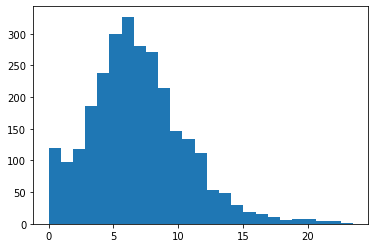

In [6]:
n_words, n_utt = [],[]
word_in_utt = []
word_in_utt_hier = []
for d in dataset:
    cur_utt = 0
    cur_words = 0
    cur_w_i_u = []
    for th in d['thread']:    
        text = wordpunct_tokenize(th['text'])
        cur_utt += 1
        cur_words += len(text)
        word_in_utt.append(len(text))
        cur_w_i_u.append(len(text))
    n_words.append(cur_words)
    n_utt.append(cur_utt)
    word_in_utt_hier.append(cur_w_i_u)
word_per_utt = [float(w)/float(u) if u > 0 else 0 for w, u in zip(n_words, n_utt)]
filter_word_per_utt = [f for f in word_per_utt if f < 25]
plot = plt.hist(filter_word_per_utt, bins=25)

In [7]:
print('\t\t\tTotal\t\tHuman-to-bot\tHuman-to-human')

hh_utt = [d for i, d in enumerate(n_utt) if human_human[i] == 1]
hb_utt = [d for i, d in enumerate(n_utt) if human_bot[i] == 1]
print('Utt. per dialogue\t%.2f\t\t%.2f\t\t%.2f' % (np.average(n_utt), np.average(hb_utt), np.average(hh_utt)))

hh_word = [np.average(d) if len(d) > 0 else 0 for i, d in enumerate(word_in_utt_hier) if human_human[i] == 1]
hb_word = [np.average(d) if len(d) > 0 else 0 for i, d in enumerate(word_in_utt_hier) if human_bot[i] == 1]
print('Word per utt.\t\t%.2f\t\t%.2f\t\t%.2f' % (np.average(word_in_utt), np.average(hb_word), np.average(hh_word)))

			Total		Human-to-bot	Human-to-human
Utt. per dialogue	10.96		10.73		12.13
Word per utt.		7.31		7.49		6.28


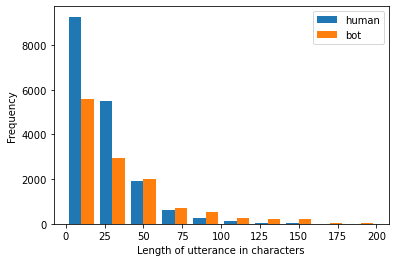

In [9]:
human_lens = []
bot_lens = []
for d in dataset:
    user_type = {}
    for user in d["users"]:
        if user["userType"] == 'Bot':
            user_type[user['id']] = False
        elif user["userType"] == 'Human':
            user_type[user['id']] = True
    for th in d["thread"]:
        if user_type[th["userId"]]:
            human_lens.append(len(th["text"]))
        else:
            bot_lens.append(len(th["text"]))
plot = plt.hist((human_lens,bot_lens), bins=10, range=(0,200), label = ('human','bot'))
plt.xlabel('Length of utterance in characters')
plt.ylabel('Frequency')
l = plt.legend()

## 2. Evaluation of dialogues

### 2.1 Dialogue-level quality

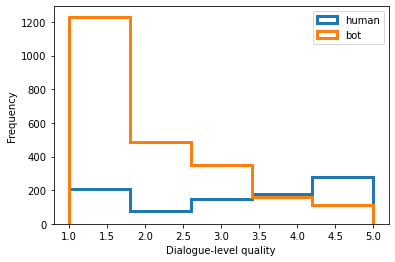

In [11]:
human_qual, bot_qual = [], []
for i, d in enumerate(dataset):
    users_map = {}
    uids = []
    users_scores = defaultdict(list)
    dbl = False
    for u in d['users']:
        uids.append(u['id'])
        if u['userType'] == 'Human':
            users_map[u['id']] = True
        elif u['userType'] == 'Bot':
            users_map[u['id']] = False
    if users_map[uids[0]] and users_map[uids[1]]:
        dbl = True
    #print(users_map)
    for ev in d['evaluation']:
        if dbl:
            human_qual.append(ev['quality'])
            continue
        if (ev['userId'] == uids[0] and not users_map[uids[0]]) or (ev['userId'] == uids[1] and not users_map[uids[1]]):
            bot_qual.append(ev['quality'])

plot = plt.hist(human_qual, bins=5, histtype='step', linewidth=3.0, label='human')
plot = plt.hist(bot_qual, bins=5, histtype='step', linewidth=3.0, label='bot')
plt.xlabel('Dialogue-level quality')
plt.ylabel('Frequency')
l = plt.legend()
#sum(bot_qual), len(bot_qual), len(human_qual)

Text(0, 0.5, 'Number of dialogues')

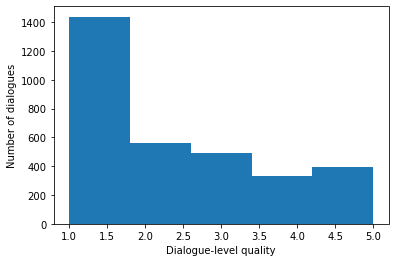

In [12]:
plot = plt.hist(human_qual + bot_qual, bins=5)
plt.xlabel('Dialogue-level quality')
plt.ylabel('Number of dialogues')

#### Correlation of dialogue-level scores

In [13]:
breadth, engagement, quality = [], [], []
qu_dbl = [[], []]
for d in dataset:
    dbl = False
    users_map = {}
    uids = []
    users_scores = defaultdict(list)
    for u in d['users']:
        uids.append(u['id'])
        if u['userType'] == 'Human':
            users_map[u['id']] = True
        elif u['userType'] == 'Bot':
            users_map[u['id']] = False
    if users_map[uids[0]] and users_map[uids[1]]:
        dbl = True
    cur_dbl_q, cur_dbl_br, cur_dbl_en = [], [], []
    for i, ev in enumerate(d['evaluation']):
        if dbl:
            cur_dbl_q.append(ev['quality'])
            cur_dbl_br.append(ev['breadth'])
            cur_dbl_en.append(ev['engagement'])
        if (ev['userId'] == uids[0] and not users_map[uids[0]]) or (ev['userId'] == uids[1] and not users_map[uids[1]]):
            breadth.append(ev['breadth'])
            engagement.append(ev['engagement'])
            quality.append(ev['quality'])
            break
    if dbl:
        breadth.append(np.average(cur_dbl_br))
        quality.append(np.average(cur_dbl_q))
        engagement.append(np.average(cur_dbl_en))
print('Breadth vs quality: ', pearsonr(breadth, quality)[0])
print('Engagement vs quality', pearsonr(engagement, quality)[0])
print('Breadth vs engagement', pearsonr(breadth, engagement)[0])

Breadth vs quality:  0.8620674211211425
Engagement vs quality 0.8665524650488547
Breadth vs engagement 0.8682743147673018


### 2.2 Utterance-level quality

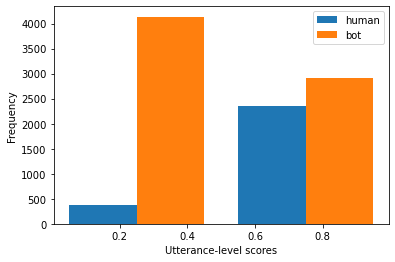

In [15]:
human_utt, bot_utt = [], []
for i, d in enumerate(dataset):
    users = {}
    for u in d['users']:
        if u['userType'] == 'Human':
            users[u['id']] = 'human'
        elif u['userType'] == 'Bot':
            users[u['id']] = 'bot'
    for th in d['thread']:
        if th['evaluation'] != 0:
            try:
                if users[th['userId']] == 'human':
                    human_utt.append(th['evaluation'] - 1)
                elif users[th['userId']] == 'bot':
                    bot_utt.append(th['evaluation'] - 1)
            except KeyError:
                print('Unknown user {} in dialogue {}'.format(th['userId'], i))
fig, ax = plt.subplots()

h_avg, h_std = np.average(human_utt), np.std(human_utt)
b_avg, b_std = np.average(bot_utt), np.std(bot_utt)
human_utt_trans = [(h - h_avg)/h_std for h in human_utt]
bot_utt_trans = [(b - b_avg)/b_std for b in bot_utt]
ax.hist((human_utt, bot_utt), bins=2, label=('human', 'bot'))
l = plt.legend()
plt.xlabel('Utterance-level scores')
plt.ylabel('Frequency')
plt.show()

#### Distribution of dialogues by number of utterance-level scores

Number of unrated utterances: 8183 (45.582664884135475%)
Number of dialogues with zero rated utterances: 1131 (40.71274298056156%)
Number of dialogues with partially rated utterances: 845 (30.417566594672426%)
61


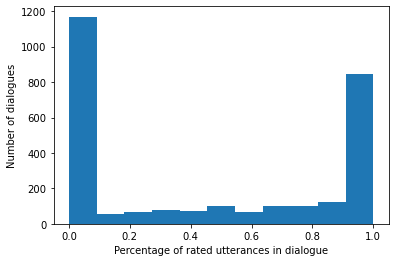

In [16]:
rated_utt = {}
rated_utt_detailed = []
all_human_eval = []
for i, d in enumerate(dataset):
    cur_rated = []
    cur_rated_user1, cur_rated_user2 = [], []
    users = {}
    for u in d['users']:
        if u['userType'] == 'Human':
            users[u['id']] = 'human'
        elif u['userType'] == 'Bot':
            users[u['id']] = 'bot'
    [user1, user2] = users.keys()
    #print(user1, user2)
    for th in d['thread']:
        if human_human[i]:
            cur_rated.append(th['evaluation'])
            all_human_eval.append(th['evaluation'])
            #print(users[th['userId']], user1, user2)
            if th['userId'] == user1:
                cur_rated_user1.append(th['evaluation'])
            elif th['userId'] == user2:
                cur_rated_user2.append(th['evaluation'])
        elif users[th['userId']] == 'bot':
            cur_rated.append(th['evaluation'])
            all_human_eval.append(th['evaluation'])
            
    percent = sum([1 for c in cur_rated if c != 0])/len(cur_rated) if len(cur_rated) > 0 else 0
    rated_utt[i] = percent
    if human_human[i]:
        rated_utt_detailed.append(cur_rated_user1)
        rated_utt_detailed.append(cur_rated_user2)
        #print('Dialogue {}, user1: '.format(i), cur_rated_user1)
        #print('Dialogue {}, user2: '.format(i), cur_rated_user2)
    else:
        rated_utt_detailed.append(cur_rated)
        #print('Dialogue {}'.format(i), cur_rated)

plot = plt.hist(rated_utt.values(), bins=11)
plt.xlabel('Percentage of rated utterances in dialogue')
plt.ylabel('Number of dialogues')
num_unrated = len([t for t in all_human_eval if t == 0])
print('Number of unrated utterances: {} ({}%)'.format(num_unrated, 100*num_unrated/len(all_human_eval)))
num_unrated_dial = len([t for t in rated_utt.values() if t == 0])
print('Number of dialogues with zero rated utterances: {} ({}%)'.format(num_unrated_dial, 100*num_unrated_dial/len(rated_utt)))
num_incomplete = len([t for t in rated_utt.values() if t > 0 and t < 1])
print('Number of dialogues with partially rated utterances: {} ({}%)'.format(num_incomplete, 100*num_incomplete/len(rated_utt)))
print(max([len(dl) for dl in rated_utt_detailed]))

In [17]:
dataset[33]

{'context': 'Scholars disagree over the effects of social status on racial classifications in Brazil. It is generally believed that achieving upward mobility and education results in individuals being classified as a category of lighter skin. The popular claim is that in Brazil, poor whites are considered black and wealthy blacks are considered white. Some scholars disagree, arguing that "whitening" of one\'s social status may be open to people of mixed race, a large part of the population known as pardo, but a person perceived as preto (black) will continue to be classified as black regardless of wealth or social status.',
 'users': [{'userType': 'Human', 'id': 'Bob'},
  {'userType': 'Human', 'id': 'Alice'}],
 'evaluation': [{'breadth': 1,
   'userId': 'Alice',
   'quality': 2,
   'engagement': 1},
  {'breadth': 3, 'userId': 'Bob', 'quality': 5, 'engagement': 3}],
 'thread': [{'evaluation': 2,
   'text': "Well that reminds me of the study of teachers' attitude towards ethnically 'othe

In [18]:
rated_long = {k: v for k, v in rated_utt.items() if k in long_dialogue}
one_rated_human = [v for k, v in rated_long.items() if human_human[k] and v > 0]
one_rated_bot = [v for k, v in rated_long.items() if human_bot[k] and v > 0]
half_rated_human = [v for k, v in rated_long.items() if human_human[k] and v >= 0.5]
half_rated_bot = [v for k, v in rated_long.items() if human_bot[k] and v >= 0.5]
all_rated_human = [v for k, v in rated_long.items() if human_human[k] and v == 1]
all_rated_bot = [v for k, v in rated_long.items() if human_bot[k] and v == 1]
one_rated = len(one_rated_human) + len(one_rated_bot)
half_rated = len(half_rated_human) + len(half_rated_bot)
all_rated = len(all_rated_human) + len(all_rated_bot)
print('Long & at least one item rated\t\t{}\t\t{}\t\t{}'.format(one_rated, len(one_rated_human), len(one_rated_bot)))
print('Long & at least half items rated\t{}\t\t{}\t\t{}'.format(half_rated, len(half_rated_human), len(half_rated_bot)))
print('Long & all items rated\t\t\t{}\t\t{}\t\t{}'.format(all_rated, len(all_rated_human), len(all_rated_bot)))
print('Average percentage of rated utterances for dialogues with at least one utterance rated: {}'.format(
    np.average(one_rated_bot + one_rated_human)))

Long & at least one item rated		1356		271		1085
Long & at least half items rated	1058		172		886
Long & all items rated			603		39		564
Average percentage of rated utterances for dialogues with at least one utterance rated: 0.7487734622508552


#### Distribution of utterance-level scores across dialogue

### 2.3 Dialogue-level vs utterance-level

Pearson r of averaged dialogue-level and utterance-level scores:  0.5994736922467443
Pearson r of dialogue quality and utterance-level scores:  0.5856503350295342
Pearson r of dialogue breadth and utterance-level scores:  0.5648290554757693
Pearson r of dialogue engagement and utterance-level scores:  0.5502532290838877


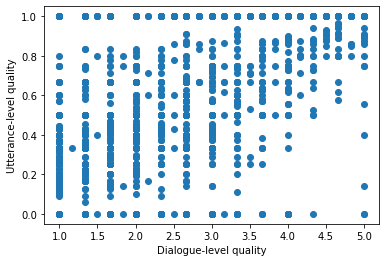

In [19]:
dialog_scores, utterance_scores = [], []
for d in dataset:
    cur_d, cur_u = [], []
    # dialogue-level
    for ev in d['evaluation']:
        for k in ['breadth', 'engagement', 'quality']:
        #for k in ['quality']:
            if ev[k] != 0:
                cur_d.append(ev[k])
    # utterance-level
    for th in d['thread']:
        if th['evaluation'] != 0:
            cur_u.append(th['evaluation']-1)
    dialog_scores.append(cur_d)
    utterance_scores.append(cur_u)
filter_dialog_scores = [np.average(d_s) for d_s, u_s in zip(dialog_scores, utterance_scores) if len(d_s) != 0 and len(u_s) != 0]
filter_utt_scores = [np.average(u_s) for d_s, u_s in zip(dialog_scores, utterance_scores) if len(d_s) != 0 and len(u_s) != 0]
filter_quality = [q for q, u in zip(quality, utterance_scores) if len(u) != 0]
filter_breadth = [q for q, u in zip(breadth, utterance_scores) if len(u) != 0]
filter_engagement = [q for q, u in zip(engagement, utterance_scores) if len(u) != 0]
filter_utt = [np.average(u) for u in utterance_scores if len(u) != 0]
assert(len(filter_dialog_scores) == len(filter_utt_scores))
#print(len(filter_dialog_scores))
print('Pearson r of averaged dialogue-level and utterance-level scores: ', pearsonr(filter_dialog_scores, filter_utt_scores)[0])
print('Pearson r of dialogue quality and utterance-level scores: ', pearsonr(filter_quality, filter_utt)[0])
print('Pearson r of dialogue breadth and utterance-level scores: ', pearsonr(filter_breadth, filter_utt)[0])
print('Pearson r of dialogue engagement and utterance-level scores: ', pearsonr(filter_engagement, filter_utt)[0])
plt.scatter(filter_dialog_scores, filter_utt_scores)
plt.xlabel('Dialogue-level quality')
p = plt.ylabel('Utterance-level quality')

### 2.4 Dialogue-level vs statistics

In [20]:
all_words = []
for d in dataset:
    cur_w = []
    for th in d['thread']:
        cur_w.extend(wordpunct_tokenize(th['text'].lower()))
    all_words.append(cur_w)
unique_words = [len(list(set(cur_w))) for cur_w in all_words]
print('Correlation of quality and # of unique words: ', pearsonr(quality, unique_words)[0])
print('Correlation of breadth and # of unique words: ', pearsonr(breadth, unique_words)[0])
print('Correlation of engagement and # of unique words: ', pearsonr(engagement, unique_words)[0])

all_dialog_lens = [len(d['thread']) for d in dataset]
print('\nCorrelation of quality and # of utterances', pearsonr(quality, all_dialog_lens)[0])
print('Correlation of breadth and # of utterances', pearsonr(breadth, all_dialog_lens)[0])
print('Correlation of engagement and # of utterances', pearsonr(engagement, all_dialog_lens)[0])

Correlation of quality and # of unique words:  0.4084908035730139
Correlation of breadth and # of unique words:  0.36360530537836067
Correlation of engagement and # of unique words:  0.4245574084423293

Correlation of quality and # of utterances 0.3206544201760928
Correlation of breadth and # of utterances 0.2825802341312935
Correlation of engagement and # of utterances 0.33363549056289554


In [21]:
from nltk import ngrams
from collections import Counter
from nltk import wordpunct_tokenize
def ngram_count(dialogue, order):
    total = []
    for th in dialogue['thread']:
        ngrams_txt = ngrams(wordpunct_tokenize(th['text']), order)
        total.extend(ngrams_txt)
    cc_total = Counter(total)
    return cc_total

trigram_distr = [len(ngram_count(d, 3)) for d in dataset]
fourgram_distr = [len(ngram_count(d, 4)) for d in dataset]
fivegram_distr = [len(ngram_count(d, 5)) for d in dataset]

print('Correlation of quality and # of unique trigrams: ', pearsonr(trigram_distr, quality)[0])
print('Correlation of breadth and # of unique trigrams: ', pearsonr(trigram_distr, breadth)[0])
print('Correlation of engagement and # of unique trigrams: ', pearsonr(trigram_distr, engagement)[0])

Correlation of quality and # of unique trigrams:  0.36818753240658386
Correlation of breadth and # of unique trigrams:  0.31869012617563286
Correlation of engagement and # of unique trigrams:  0.3866234627302393


## 3. Topicality of conversations

In [22]:
# Do the users or bots use context as a topic for conversations?
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

all_contexts = []
all_contexts_trans = []
for d in dataset:
    all_contexts.append(d['context'])

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, PorterStemmer())
    return stems

for cont in all_contexts:
    lowers = cont.lower()
    no_punctuation = ''.join([l for l in lowers if l not in string.punctuation])
    all_contexts_trans.append(no_punctuation)
        
#this can take some time
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
tfs = tfidf.fit_transform(all_contexts_trans)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

In [25]:
# get words from the most informative (according to tf-idf) context word list that occur in the dialogue
def get_intersections(sentences, context):
    tr_table = {s: "" for s in string.punctuation}
    feature_names = tfidf.get_feature_names()
    response = tfidf.transform([context])
    words_from_cont = []
    for s in sentences:
        lowers = s.lower()
        no_punctuation = ''.join([l for l in lowers if l not in string.punctuation])
        txt = tokenize(no_punctuation)
        top15 = sorted([(feature_names[c], response[0,c]) for c in response.nonzero()[1]], reverse=True)[:15]
        cont_words = [w for w, c in top15]
        txt_common = [t for t in txt if t in cont_words]
        words_from_cont.extend(txt_common)
    return words_from_cont

all_common_words = []
for i, d in enumerate(dataset):
    all_utt = [th['text'] for th in d['thread']]
    ss = get_intersections(all_utt, all_contexts[i])
    all_common_words.append(ss)

all_lens = [len(a) for a in all_common_words]
print('Min. number of topic words: ', min(all_lens))
print('Max. number of topic words: ', max(all_lens))
print('Average number of topic words: {}, std.deviation: {}'.format(np.average(all_lens), np.std(all_lens)))

Min. number of topic words:  0
Max. number of topic words:  51
Average number of topic words: 1.7491000719942404, std.deviation: 3.028073752670609


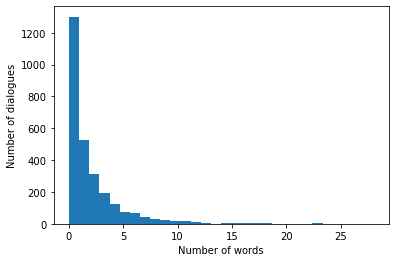

In [26]:
all_lens_below_30 = [a for a in all_lens if a < 30]
plot = plt.hist(all_lens_below_30, bins=30)
plt.xlabel('Number of words')
p = plt.ylabel('Number of dialogues')

In [27]:
print('Correlation of dialogue-level quality and topicality: ', pearsonr(quality, all_lens)[0])
print('Correlation of dialogue-level breadth and topicality: ', pearsonr(breadth, all_lens)[0])
print('Correlation of dialogue-level engagement and topicality: ', pearsonr(engagement, all_lens)[0])
non_zero_q = [q for q, a in zip(quality, all_lens) if a != 0]
non_zero_b = [q for q, a in zip(breadth, all_lens) if a != 0]
non_zero_e = [q for q, a in zip(engagement, all_lens) if a != 0]
non_zero_a = [a for a in all_lens if a != 0]
print('\nQuality vs topicality for dialogues which contain at least 1 topic word: ', pearsonr(non_zero_q, non_zero_a)[0])
print('Breadth vs topicality for dialogues which contain at least 1 topic word: ', pearsonr(non_zero_b, non_zero_a)[0])
print('Engagement vs topicality for dialogues which contain at least 1 topic word: ', pearsonr(non_zero_e, non_zero_a)[0])

Correlation of dialogue-level quality and topicality:  0.19306094356000675
Correlation of dialogue-level breadth and topicality:  0.16946140902709494
Correlation of dialogue-level engagement and topicality:  0.19899037902084069

Quality vs topicality for dialogues which contain at least 1 topic word:  0.11927213021959487
Breadth vs topicality for dialogues which contain at least 1 topic word:  0.09001728038235818
Engagement vs topicality for dialogues which contain at least 1 topic word:  0.11396311070616341


# Research on chatbot and user initiative

## Initiative metrics

### Utterance Length

In [11]:
from scipy.stats import norm

def calc_utt_len(dataset):
    n_words, n_utt = [],[]
    word_in_utt = []
    word_in_utt_hier = []
    for d in dataset:
        cur_utt = 0
        cur_words = 0
        cur_w_i_u = []
        for th in d['thread']:    
            text = wordpunct_tokenize(th['text'])
            cur_utt += 1
            cur_words += len(text)
            word_in_utt.append(len(text))
            cur_w_i_u.append(len(text))
        n_words.append(cur_words)
        n_utt.append(cur_utt)
        word_in_utt_hier.append(cur_w_i_u)
    word_per_utt = [float(w)/float(u) if u > 0 else 0 for w, u in zip(n_words, n_utt)]
    filter_word_per_utt = [f for f in word_per_utt if f < 25]
    return filter_word_per_utt

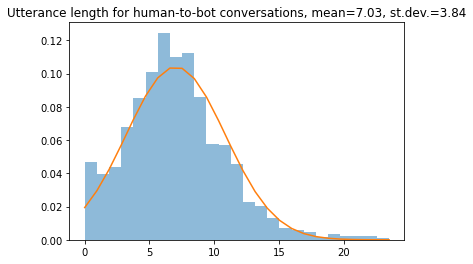

In [35]:
def get_hist_with_norm_dist(data, title):
    _, bins, _ = plt.hist(data, bins=25, density=1, alpha=0.5)
    mu, sigma = norm.fit(data)
    best_fit_line = norm.pdf(bins, mu, sigma)
    plt.plot(bins, best_fit_line)
    plt.title(f'{title}, mean={round(mu,2)}, st.dev.={round(sigma,2)}')

get_hist_with_norm_dist(calc_utt_len(hb_dialog), "Utterance length for human-to-bot conversations")

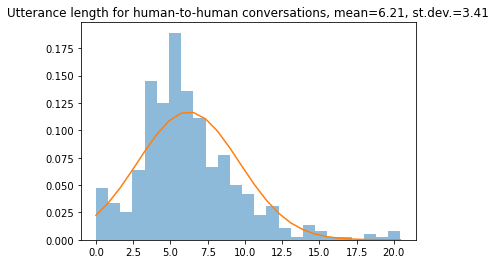

In [36]:
get_hist_with_norm_dist(calc_utt_len(hh_dialog), "Utterance length for human-to-human conversations")

### Noun Phrases

In [52]:
# !pip install spacy
# !python -m spacy download en_core_web_sm
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()

# Just an example, has to be extended to the whole dataset
def get_NPs(dataset):
    result = []
    for d in dataset:
        for th in d['thread']:  
            phrases = set() 
            doc = nlp(th['text'])
            for nc in doc.noun_chunks:
                phrases.add(nc.text)
                phrases.add(doc[nc.root.left_edge.i:nc.root.right_edge.i+1].text)
            result.append(phrases)
        return result

In [53]:
import pprint

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(hb_dialog[0])
get_NPs(hb_dialog)

{   'context': 'Though much of Enlightenment political thought was dominated '
               'by social contract theorists, both David Hume and Adam '
               "Ferguson criticized this camp. Hume's essay Of the Original "
               'Contract argues that governments derived from consent are '
               "rarely seen, and civil government is grounded in a ruler's "
               'habitual authority and force. It is precisely because of the '
               "ruler's authority over-and-against the subject, that the "
               'subject tacitly consents; Hume says that the subjects would '
               '"never imagine that their consent made him sovereign", rather '
               'the authority did so. Similarly, Ferguson did not believe '
               'citizens built the state, rather polities grew out of social '
               'development. In his 1767 An Essay on the History of Civil '
               'Society, Ferguson uses the four stages of progress, a theo

[set(),
 {'Who',
  'civil society',
  'the four stages',
  'the four stages of civil society'},
 {'Hint', 'Hint:', 'first 3 answer letters'},
 {'What', 'your name'},
 {'What'},
 {'me'},
 {'It', 'energy', 'me'}]

### Negative Log Likelihood

[Code from here](https://towardsdatascience.com/text-generation-with-python-and-gpt-2-1fecbff1635b)

In [2]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# initialize tokenizer and model from pretrained GPT2 model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [3]:
sequence = "Valeria is studying late at night because she worked all day long"
inputs = tokenizer.encode(sequence, return_tensors='pt')
outputs = model.generate(inputs, max_length=200, do_sample=True)
text = tokenizer.decode(outputs[0], skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [4]:
text

"Valeria is studying late at night because she worked all day long, her phone still ringing the sound of it on her desk, the music playing inside her head. Her hand slips back and forth through her shirt underneath her jeans, a towel in one hand, her lipstick in the other.\n\nThe sun is starting to set, as does the light. The sun is setting and the sun is back out on that patio with the wind. They are playing ping pong together, a bit of a sport, mostly, maybe I should say, because here I've been playing. The sun is the greatest part of me now.\n\nShe has so much to learn, the biggest of which is to realize what it is you are doing. It isn't going to get long enough for this world to settle its own balance, or even settle itself. I don't know how long it will last, though. I hope I can do a little of that.\n\nCue light and"

From the paper:
> To calculate negative log-likelihood and entropy (avg. negative log-likelihood), we used a GPT-2 medium model (Radford et al., 2019), which was pre-trained on the English Webtext dataset and has 345M parameters. We fine-tuned this model on 130,000 examples of dialogue from our bot, where each example contained a single user utterance. This was divided into a training split with 91,000 examples and a validation split with 39,000 examples. During fine-tuning, we used the default hyperparameters and selected the model with the lowest negative log-likelihood loss (3.19) and had been trained for 4 epochs. The model was trained on a Titan RTX using a single GPU and 24 GB of memory. Training took 5 hours and 22 minutes.